In [25]:
!which python

/Users/ahmadabdullahtariq/Documents/Projects/Thesis/.venv/bin/python


In [5]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR,LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# df = pd.read_pickle('../dataset/preprocessed/284_imputed.pkl')
df = pd.read_pickle('../dataset/preprocessed/1479_imputed.pkl')


print(df.isna().sum())

print(df.dtypes)

DOA              0
LeadTime         0
DOW              0
Price            0
TotalCapacity    0
ROH              0
dtype: int64
DOA              datetime64[ns]
LeadTime                  int64
DOW                       int64
Price                   float64
TotalCapacity           float64
ROH                     float64
dtype: object


In [3]:
# df = df[df['LeadTime']==89]
df = df.rename(columns={'Reservations':'ROH'})

# SVR
- https://stats.stackexchange.com/questions/82044/how-does-support-vector-regression-work-intuitively
- https://stats.stackexchange.com/questions/13194/support-vector-machines-and-regression

In [4]:
df.head()

,DOA,LeadTime,DOW,Price,TotalCapacity,ROH
0,2018-01-01,27,0,80.1,226.0,194.0
1,2018-01-01,26,0,80.1,226.0,194.0
2,2018-01-01,25,0,80.1,226.0,194.0
3,2018-01-01,24,0,80.1,226.0,194.0
4,2018-01-01,21,0,80.1,226.0,194.0


<AxesSubplot:>

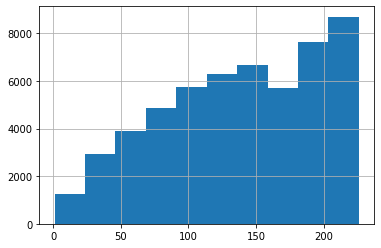

In [5]:
df['ROH'].hist()

In [6]:
df.loc[(df['Price'] > 154)&(df['DOA'] == 0), 'Price'] = df['Price'].median()
df.loc[(df['ROH'] < 150)&(df['DOA'] == 0), 'ROH'] = df['ROH'].median()

In [7]:
df.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
DOA,53705,722,2019-07-29,90,2018-01-01,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LeadTime,53705,NaN,NaT,NaN,NaT,NaT,41.3619,25.6457,0,19,40,63,89
DOW,53705,NaN,NaT,NaN,NaT,NaT,3.00441,2.01046,0,1,3,5,6
Price,53705,NaN,NaT,NaN,NaT,NaT,99.7211,40.8822,47.4,71.1,89.1,116.1,505
TotalCapacity,53705,NaN,NaT,NaN,NaT,NaT,225.685,1.27249,210,226,226,226,226
ROH,53705,NaN,NaT,NaN,NaT,NaT,137.378,58.1187,1,92,142,190,226


In [8]:
dx = df[df['LeadTime']==0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dx.DOA, y=dx.Price,mode='markers+lines',name='ROH'))
fig.update_layout(autosize=False,width=1000,height=300,xaxis_title="Reservations on Hand (ROH)",yaxis_title="Day of Arrival (DOA)")
fig.show()   

## Train Test split 

In [9]:
# This is a hack to combine both datetime columns
from datetime import timedelta ,datetime
df['DOA'] = df['DOA']+df['LeadTime'].apply(lambda x: timedelta(minutes=(1440-((x+1)*16)))) 

timestamp_s = df['DOA'].map(datetime.timestamp)

In [10]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

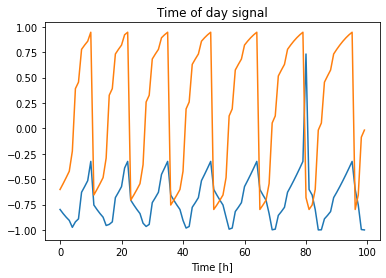

In [11]:
plt.plot(np.array(df['Day sin'])[:100])
plt.plot(np.array(df['Day cos'])[:100])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [12]:
df = df.set_index('DOA')   

In [13]:
df = df.drop(columns='TotalCapacity')

In [14]:
scaler = StandardScaler()
df[['LeadTime','DOW','Price','ROH']] = scaler.fit_transform(df[['LeadTime','DOW','Price','ROH']])

In [15]:
df

,LeadTime,DOW,Price,ROH,Day sin,Day cos,Year sin,Year cos
DOA,,,,,,,,
2018-01-01 16:32:00,-0.560018,-1.494408,-0.479948,0.974255,-0.798636,-0.601815,0.017326,0.999850
2018-01-01 16:48:00,-0.599011,-1.494408,-0.479948,0.974255,-0.838671,-0.544639,0.017517,0.999847
2018-01-01 17:04:00,-0.638004,-1.494408,-0.479948,0.974255,-0.874620,-0.484810,0.017708,0.999843
2018-01-01 17:20:00,-0.676998,-1.494408,-0.479948,0.974255,-0.906308,-0.422618,0.017899,0.999840
2018-01-01 18:08:00,-0.793977,-1.494408,-0.479948,0.974255,-0.974370,-0.224951,0.018473,0.999829
...,...,...,...,...,...,...,...,...
2019-12-31 22:40:00,-1.456862,-0.997004,6.256547,1.352794,-0.573576,0.819152,-0.003823,0.999993
2019-12-31 22:56:00,-1.495856,-0.997004,6.256547,1.318382,-0.515038,0.857167,-0.003632,0.999993
2019-12-31 23:12:00,-1.534849,-0.997004,6.256547,1.301175,-0.453990,0.891007,-0.003441,0.999994


In [16]:
train     = df.loc[:'2019-10']
test      = df.loc['2019-10':]

In [17]:
y = train.pop('ROH')
X = train

In [18]:
svm_reg = LinearSVR(epsilon=1.5)
model_reg = svm_reg.fit(X, y)
test['svm_reg'] = svm_reg.predict(test.loc[:, test.columns != 'ROH']) 

In [19]:
svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=.1)
model_rbf = svr_rbf.fit(X, y)
test['svm_rbf'] = model_rbf.predict(test[['LeadTime','DOW','Price','Day sin','Day cos','Year sin','Year cos']]) 

In [20]:
dx = test[test['LeadTime']==test['LeadTime'].max()]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dx.index, y=dx['ROH'],mode='markers+lines',name='True'))
fig.add_trace(go.Scatter(x=dx.index, y=dx['svm_reg'],mode='markers+lines',name='svm_reg'))
fig.add_trace(go.Scatter(x=dx.index, y=dx['svm_rbf'],mode='markers+lines',name='svm_rbf'))

fig.update_layout(autosize=False,width=1000,height=400,xaxis_title="Reservations on Hand (ROH)",yaxis_title="Day of Arrival (DOA)")
fig.show()   

In [21]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

mse = mean_squared_error(test['ROH'], test['svm_reg'])
mae = mean_absolute_error(test['ROH'], test['svm_reg'])
r2  = r2_score(test['ROH'], test['svm_reg'])

print('SVM Reg MSE: %0.3f MAE: %0.3f R2: %03f'%(mse,mae,r2))

mse = mean_squared_error(test['ROH'], test['svm_rbf'])
mae = mean_absolute_error(test['ROH'], test['svm_rbf'])
r2  = r2_score(test['ROH'], test['svm_rbf'])

print('SVM Rbf MSE: %0.3f MAE: %0.3f R2: %03f'%(mse,mae,r2))

SVM Reg MSE: 0.905 MAE: 0.836 R2: 0.071956
SVM Rbf MSE: 0.666 MAE: 0.589 R2: 0.317348


In [22]:
from sklearn.model_selection import cross_validate

scoring = {'r2':'r2', 'MSE':'neg_mean_squared_error'}
for degree in range(2,7):
    res = cross_validate(polynomialRegression(degree), X, y, cv=270,scoring=scoring, return_train_score=True)
    
    print("Poly degree:",degree)
    print("R2  Test Score: %0.2f (+/- %0.2f)) | Train Score: %0.2f (+/- %0.2f))"%(res['test_r2'].mean(),res['test_r2'].std()* 2,res['train_r2'].mean(),res['train_r2'].std()* 2))
    print("MSE Test Score: %0.2f (+/- %0.2f)) | Train Score: %0.2f (+/- %0.2f))"%(res['test_MSE'].mean(),res['test_MSE'].std()* 2,res['train_MSE'].mean(),res['train_MSE'].std()* 2))
    print("RMSE Test Score: %0.2f (+/- %0.2f)) | Train Score: %0.2f (+/- %0.2f))"%(np.sqrt(-res['test_MSE']).mean(),np.sqrt(-res['test_MSE']).std()* 2,np.sqrt(-res['train_MSE']).mean(),np.sqrt(-res['test_MSE']).std()* 2))

NameError: name 'polynomialRegression' is not defined

# With ROH

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR,LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
df = pd.read_pickle('../dataset/preprocessed/284_imputed.pkl')
# df = pd.read_pickle('../dataset/preprocessed/1479_imputed.pkl')

In [3]:
df.head()

,DOA,LeadTime,DOW,Price,TotalCapacity,ROH
0,2018-01-01,88,0,76.05,290.0,58.0
1,2018-01-01,87,0,76.05,290.0,58.0
2,2018-01-01,85,0,76.05,290.0,58.0
3,2018-01-01,81,0,76.05,290.0,63.0
4,2018-01-01,80,0,76.05,290.0,62.0


In [4]:
df = df.rename(columns={'Reservations':'ROH'})
scaler = StandardScaler()
df[['DOW','Price','ROH']] = scaler.fit_transform(df[['DOW','Price','ROH']])
df = df.pivot(index='DOA',columns='LeadTime',values='ROH')
df = df.bfill(axis=1).ffill(axis=1)

In [5]:
# df = df.drop(columns=[1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,19,21])
cols = df.columns[df.columns.isin([89,79,69,59,49,39,29,19,9,0])]
df = df[cols]

In [6]:
df['DOW'] = df.index.dayofweek

In [7]:
df.head()

LeadTime,0,9,19,29,39,49,59,69,79,89,DOW
DOA,,,,,,,,,,,
2018-01-01,1.112380,0.832724,0.622982,0.301378,0.035705,-0.174036,-0.565554,-0.803262,-0.943090,-0.999021,0
2018-01-02,1.308139,0.776793,0.385275,0.119602,-0.160054,-0.453692,-0.747331,-0.971055,-1.082917,-1.138849,1
2018-01-03,1.517881,0.553069,0.049688,-0.202002,-0.411744,-0.789279,-0.985038,-1.152831,-1.250711,-1.306642,2
2018-01-04,1.461950,0.315361,0.021723,-0.551572,-0.719365,-0.985038,-1.096900,-1.264694,-1.348590,-1.362573,3
2018-01-05,1.839485,0.399258,-0.202002,-0.579537,-0.901141,-1.040969,-1.194780,-1.306642,-1.404521,-1.446470,4


In [18]:
from sklearn.model_selection import KFold

df_train    = df.loc[:'2019-10']
df_test     = df.loc['2019-10':]

y = df_train.pop(0)
X = df_train

result = {'train':[],'test':[]}
kf = KFold(random_state=None, shuffle=False, n_splits=16)

for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=.1)
    model_rbf = svr_rbf.fit(X_train, y_train)

    # svm_reg = LinearSVR(epsilon=0.5)
    # model_rbf = svm_reg.fit(X_train, y_train) # temp name change
    
    train_svm_rbf = model_rbf.predict(X_train)     
    test_svm_rbf = model_rbf.predict(X_test) 

    train_rmse = np.mean((y_train - train_svm_rbf)**2)**.5  # RMSE
    test_rmse = np.mean((y_test - test_svm_rbf)**2)**.5  # RMSE
    result['train'].append(train_rmse)
    result['test'].append(test_rmse)
    print("Train RMSE ::",round(train_rmse,3),"\tTest RMSE ::",round(test_rmse,3))

print("Mean Train RMSE ::",round(np.mean(result['train']),3),"\tMean Test RMSE ::",round(np.mean(result['test']),3))


Train RMSE :: 0.234 	Test RMSE :: 0.4
Train RMSE :: 0.24 	Test RMSE :: 0.203
Train RMSE :: 0.241 	Test RMSE :: 0.197
Train RMSE :: 0.233 	Test RMSE :: 0.326
Train RMSE :: 0.237 	Test RMSE :: 0.237
Train RMSE :: 0.229 	Test RMSE :: 0.369
Train RMSE :: 0.235 	Test RMSE :: 0.308
Train RMSE :: 0.243 	Test RMSE :: 0.111
Train RMSE :: 0.18 	Test RMSE :: 0.679
Train RMSE :: 0.244 	Test RMSE :: 0.129
Train RMSE :: 0.243 	Test RMSE :: 0.097
Train RMSE :: 0.242 	Test RMSE :: 0.136
Train RMSE :: 0.241 	Test RMSE :: 0.126
Train RMSE :: 0.24 	Test RMSE :: 0.188
Train RMSE :: 0.243 	Test RMSE :: 0.112
Train RMSE :: 0.243 	Test RMSE :: 0.144
Mean Train RMSE :: 0.236 	Mean Test RMSE :: 0.235


In [10]:
# from sklearn.model_selection import TimeSeriesSplit

# df_train    = df.loc[:'2019-10']
# df_test     = df.loc['2019-10':]

# y = df_train.pop(0)
# X = df_train

# tscv = TimeSeriesSplit(max_train_size=None, n_splits=10)

# for train_index, test_index in tscv.split(X):
#     # print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=.1)
#     model_rbf = svr_rbf.fit(X_train, y_train)

#     # svm_reg = LinearSVR(epsilon=0.5)
#     # model_rbf = svm_reg.fit(X_train, y_train) # temp name change
    
#     train_svm_rbf = model_rbf.predict(X_train)     
#     test_svm_rbf = model_rbf.predict(X_test) 

#     train_rmse = np.mean((y_train - train_svm_rbf)**2)**.5  # RMSE
#     test_rmse = np.mean((y_test - test_svm_rbf)**2)**.5  # RMSE

#     print("Train RMSE ::",round(train_rmse,3),"\tTest RMSE ::",round(test_rmse,3))


In [19]:
pred = model_rbf.predict(df_test.loc[:, df_test.columns != 0]) 

In [20]:
df_test['svm_rbf'] = pred

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test.index, y=df_test[0],mode='markers+lines',name='True'))
# fig.add_trace(go.Scatter(x=df_test.index, y=df_test['svm_reg'],mode='markers+lines',name='svm_reg'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['svm_rbf'],mode='markers+lines',name='svm_rbf'))

fig.update_layout(autosize=False,width=1000,height=400,xaxis_title="Reservations on Hand (ROH)",yaxis_title="Day of Arrival (DOA)")
fig.show()   

In [12]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae  = np.mean(np.abs(forecast - actual))    # MAE
    mpe  = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':round(mape,3), 'mae':round(mae,3) , 'mpe':round(mpe,3) , 'rmse':round(rmse,3)})

In [23]:
# print("SVM Regression ",forecast_accuracy(df_test['svm_reg'],df_test[0]))
print("SVM Radial     ",forecast_accuracy(df_test['svm_rbf'],df_test[0]))

SVM Radial      {'mape': 0.289, 'mae': 0.212, 'mpe': 0.254, 'rmse': 0.333}


# Compile

In [6]:
from sklearn.model_selection import KFold

In [7]:
clean_hotels = [1041, 269, 4290, 48, 317, 151, 322, 1968, 1100, 284, 86, 199, 80, 577, 148, 1479] 
_result = {hotelId:{'mae':None,'rmse':None} for hotelId in clean_hotels}

In [13]:
for hotelId in clean_hotels:
    df = pd.read_pickle('../dataset/preprocessed/'+str(hotelId)+'_imputed.pkl')
    #preprocessing 
    df = df.rename(columns={'Reservations':'ROH'})
    scaler = StandardScaler()
    df[['LAR','ROH']] = scaler.fit_transform(df[['LAR','ROH']])
    df = df.pivot(index='DOA',columns='DBA',values='ROH')
    df = df.bfill(axis=1).ffill(axis=1)
    # df = df.drop(columns=[1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,19,21])
    cols = df.columns[df.columns.isin([89,79,69,59,49,39,29,19,9,0])]
    df = df[cols]
    # df['DOW'] = df.index.dayofweek
    #kfold validation 

    df_train    = df.loc[:'2019-10']
    df_test     = df.loc['2019-10':]

    y = df_train.pop(0)
    X = df_train

    result = {'train':[],'test':[]}
    kf = KFold(random_state=None, shuffle=False, n_splits=16)

    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=.1)
        model_rbf = svr_rbf.fit(X_train, y_train)

        # svm_reg = LinearSVR(epsilon=0.5)
        # model_rbf = svm_reg.fit(X_train, y_train) # temp name change
        
        train_svm_rbf = model_rbf.predict(X_train)     
        test_svm_rbf = model_rbf.predict(X_test) 

        train_rmse = np.mean((y_train - train_svm_rbf)**2)**.5  # RMSE
        test_rmse = np.mean((y_test - test_svm_rbf)**2)**.5  # RMSE
        result['train'].append(train_rmse)
        result['test'].append(test_rmse)
        # print("Train RMSE ::",round(train_rmse,3),"\tTest RMSE ::",round(test_rmse,3))

    print("Mean Train RMSE ::",round(np.mean(result['train']),3),"\tMean Test RMSE ::",round(np.mean(result['test']),3))
    #predict 
    pred = model_rbf.predict(df_test.loc[:, df_test.columns != 0]) 
    df_test['svm_rbf'] = pred
    # result 
    # fig = go.Figure()
    # fig.add_trace(go.Scatter(x=df_test.index, y=df_test[0],mode='markers+lines',name='True'))
    # # fig.add_trace(go.Scatter(x=df_test.index, y=df_test['svm_reg'],mode='markers+lines',name='svm_reg'))
    # fig.add_trace(go.Scatter(x=df_test.index, y=df_test['svm_rbf'],mode='markers+lines',name='svm_rbf'))

    # fig.update_layout(autosize=False,width=1000,height=400,xaxis_title="Reservations on Hand (ROH)",yaxis_title="Day of Arrival (DOA)")
    # fig.show()   
    # performance
    perfor = forecast_accuracy(df_test['svm_rbf'],df_test[0])
    print("SVM Radial     ",perfor)
    _result[hotelId]['mae'] = perfor['mae']
    _result[hotelId]['rmse'] = perfor['rmse']


Mean Train RMSE :: 0.202 	Mean Test RMSE :: 0.218
SVM Radial      {'mape': 0.299, 'mae': 0.14, 'mpe': 0.071, 'rmse': 0.198}
Mean Train RMSE :: 0.224 	Mean Test RMSE :: 0.227
SVM Radial      {'mape': 0.215, 'mae': 0.098, 'mpe': 0.141, 'rmse': 0.143}
Mean Train RMSE :: 0.444 	Mean Test RMSE :: 0.479
SVM Radial      {'mape': 0.109, 'mae': 0.069, 'mpe': 0.04, 'rmse': 0.089}
Mean Train RMSE :: 0.224 	Mean Test RMSE :: 0.227
SVM Radial      {'mape': 0.215, 'mae': 0.098, 'mpe': 0.141, 'rmse': 0.143}
Mean Train RMSE :: 0.094 	Mean Test RMSE :: 0.113
SVM Radial      {'mape': 0.08, 'mae': 0.075, 'mpe': 0.005, 'rmse': 0.094}
Mean Train RMSE :: 0.103 	Mean Test RMSE :: 0.134
SVM Radial      {'mape': 0.094, 'mae': 0.085, 'mpe': 0.022, 'rmse': 0.109}
Mean Train RMSE :: 0.145 	Mean Test RMSE :: 0.162
SVM Radial      {'mape': 0.096, 'mae': 0.099, 'mpe': -0.016, 'rmse': 0.156}
Mean Train RMSE :: 0.095 	Mean Test RMSE :: 0.134
SVM Radial      {'mape': 0.241, 'mae': 0.173, 'mpe': -0.07, 'rmse': 0.373}
Me

In [ ]:
_result